<a href="https://colab.research.google.com/github/CalculatedContent/ww-phys_theory/blob/master/Jacobians_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
thismodel = 'resnet164bn_cifar10'
inum_start = 0

In [3]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=fc9c598662583cf9f3410e210c9789029afd98c2d33b0ad81d628579bb84a6f3
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [4]:
!pip install pytorchcv
!pip install powerlaw

     |████████████████████████████████| 440kB 4.8MB/s 
  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24787 sha256=bc554e9c67dfb4bc1aa0d23e743cb511575dace16160d26b7f305e21ff62fd57
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw
time: 6.23 s


In [5]:
!pip install GPUtil
import GPUtil


GPUtil.showUtilization()

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=76133e2c70801ebfd078dbd7a38c838596a8fe124b1928d8291e222e85531a6b
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
time: 3.16 s


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 5min 3s


In [7]:
Jdir =  '/content/drive/My Drive/jacobians'

time: 970 µs


In [8]:
#!mkdir "$Jdir"
!ls "$Jdir"

Jdiag_resnet20_cifar10_0.csv	  Jdiag_resnet272bn_cifar10_3.csv
Jdiag_resnet20_cifar10_1.csv	  Jdiag_resnet272bn_cifar10_40.csv
Jdiag_resnet20_cifar10_2.csv	  Jdiag_resnet272bn_cifar10_41.csv
Jdiag_resnet20_cifar10_3.csv	  Jdiag_resnet272bn_cifar10_42.csv
Jdiag_resnet20_cifar10_4.csv	  Jdiag_resnet272bn_cifar10_43.csv
Jdiag_resnet20_cifar10_5.csv	  Jdiag_resnet272bn_cifar10_44.csv
Jdiag_resnet20_cifar10_6.csv	  Jdiag_resnet272bn_cifar10_45.csv
Jdiag_resnet20_cifar10_7.csv	  Jdiag_resnet272bn_cifar10_46.csv
Jdiag_resnet20_cifar10_8.csv	  Jdiag_resnet272bn_cifar10_47.csv
Jdiag_resnet20_cifar10_9.csv	  Jdiag_resnet272bn_cifar10_48.csv
Jdiag_resnet272bn_cifar10_0.csv   Jdiag_resnet272bn_cifar10_49.csv
Jdiag_resnet272bn_cifar10_10.csv  Jdiag_resnet272bn_cifar10_4.csv
Jdiag_resnet272bn_cifar10_11.csv  Jdiag_resnet272bn_cifar10_5.csv
Jdiag_resnet272bn_cifar10_12.csv  Jdiag_resnet272bn_cifar10_6.csv
Jdiag_resnet272bn_cifar10_13.csv  Jdiag_resnet272bn_cifar10_7.csv
Jdiag_resnet272bn_cifar10_14.c

In [9]:
!cd "$Jdir";pwd

/content/drive/My Drive/jacobians
time: 1.24 s


In [10]:
!import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy


/bin/bash: import: command not found
time: 4.36 s


In [11]:
def get_data(batch_size=100, train_range=None, test_range=None):
  normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
  transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])
  transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])
  train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)
  test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)  
  
  if train_range:
      train_dataset = torch.utils.data.Subset(train_dataset, train_range)

  if test_range:
      teat_dataset = torch.utils.data.Subset(test_dataset, test_range)


  train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size,
                          num_workers=4,
                          shuffle=False)
  test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         num_workers=4,
                         shuffle=False)
  return train_dataset, test_dataset, train_loader, test_loader

time: 10.1 ms


### $J^{T}J$ Diagonal elements



In [12]:

def jacobian_diagonal(model, data_loader, batch_size, num_classes=10, device='cuda:0', data_dim=3*32*32):
  '''compute J(J*v) diagnonal elements , where J is the jacobian,'''

  # compute Jdiag
  Jdiag = []
  model = model.to(device)

  for batch, data in enumerate(data_loader):
    print(batch)
    features, _ = data
    features = features.to(device)

    start_time = time.time()
    J = torch.autograd.functional.jacobian(model, features)# create_graph=True)
    #print("--- %s J tool seconds ---" % (time.time() - start_time))

    start_time = time.time()
    J = J.view(batch_size,num_classes*batch_size*data_dim)
    Jt = J.clone().transpose_(0,1)
    batch_diag = torch.mm(J,Jt).to('cpu')
    #print("--- %s JJ took seconds ---" % (time.time() - start_time))
    
    del J, Jt
    torch.cuda.empty_cache()

    for ib in range(batch_size):
      Jdiag.append(batch_diag[ib, ib].to('cpu').numpy())

    del batch_diag
    torch.cuda.empty_cache()

  return np.array(Jdiag)


time: 12 ms


### ResNet 

In [13]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

import powerlaw
for modelname in pytorchcv.model_provider._models.keys():
    if modelname.startswith('resnet') and modelname.endswith('cifar10'):
        print(modelname)

resnet20_cifar10
resnet56_cifar10
resnet110_cifar10
resnet164bn_cifar10
resnet272bn_cifar10
resnet542bn_cifar10
resnet1001_cifar10
resnet1202_cifar10
time: 88.4 ms


In [14]:
num_classes= 10
batch_size = 100
device = 'cuda:0'

num_data = 50000
train_dataset, _, train_loader, _ = get_data(batch_size=batch_size, train_range=range(1000))

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
time: 6.83 s


this model found resnet164bn_cifar10
num 0
Files already downloaded and verified
Files already downloaded and verified
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


resnet164bn_cifar10 3.8755941103970657


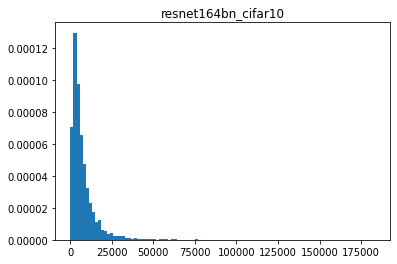

num 1
Files already downloaded and verified
Files already downloaded and verified
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Calculating best minimal value for power law fit


resnet164bn_cifar10 3.3496749581257617


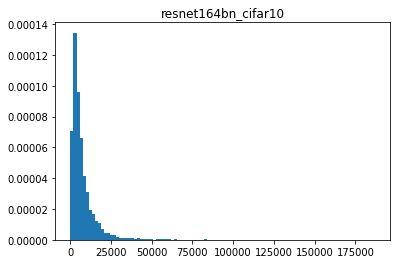

num 2
Files already downloaded and verified
Files already downloaded and verified
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Calculating best minimal value for power law fit


resnet164bn_cifar10 3.5266772708939604


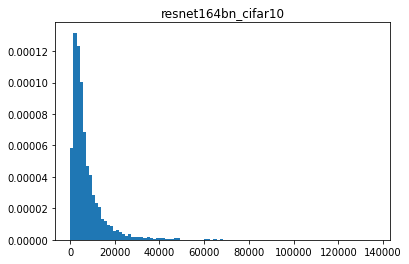

num 3
Files already downloaded and verified
Files already downloaded and verified
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


In [0]:
import powerlaw
for modelname in pytorchcv.model_provider._models.keys():
    if modelname == thismodel:
      print("this model found {}".format(modelname))
      for num in range(inum_start, 10):
        print("num {}".format(num))
        istart = num*5000
        iend = (num+1)*5000
        train_dataset, _, train_loader, _ = get_data(batch_size=batch_size, train_range=range(istart, iend))

        model = ptcv_get_model(modelname, pretrained=True)
        Jdiag = jacobian_diagonal(model, train_loader, batch_size)
        
        results = powerlaw.Fit(Jdiag)
        alpha = results.power_law.alpha
        print(modelname,alpha)

        plt.hist(Jdiag, bins=100, density=True)
        plt.title(modelname)
        plt.show()

        filename = "{}/Jdiag_{}_{}.csv".format(Jdir, modelname, num)
        np.savetxt(filename, Jdiag, delimiter='\t')

In [0]:
!ls "$Jdir"


In [0]:
!ls drive